# HW07 - Instrumental Variables (due 16 Nov 2023)

In this homework you will practice with running IV regressions with python. You will investigate once more the effect of schooling on earnings, but this time the instrument for education you will use is college proximity to individuals houses (reference paper by [Card, 1993](https://davidcard.berkeley.edu/papers/geo_var_schooling.pdf)).

More in detail, there are two instruments that can be exploited in this context. Both are binary variables taking value 1 if either a 2-years or 4-years college is present in the area where the individual lives.

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm

from linearmodels.iv import IV2SLS
from statsmodels.iolib.summary2 import summary_col
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings = lambda *a, **kw: None

df = pd.read_stata('http://www.stata.com/data/jwooldridge/eacsap/card.dta')
pd.read_stata('http://www.stata.com/data/jwooldridge/eacsap/card.dta', iterator=True).variable_labels()

{'id': '',
 'nearc2': '=1 if near 2 yr college, 1966',
 'nearc4': '=1 if near 4 yr college, 1966',
 'educ': 'years of schooling, 1976',
 'age': 'in years',
 'fatheduc': "father's schooling",
 'motheduc': "mother's schooling",
 'weight': 'NLS sampling weight, 1976',
 'momdad14': '=1 if live with mom, dad at 14',
 'sinmom14': '=1 if with single mom at 14',
 'step14': '=1 if with step parent at 14',
 'reg661': 'regional dummy, 1966',
 'reg662': '',
 'reg663': '',
 'reg664': '',
 'reg665': '',
 'reg666': '',
 'reg667': '',
 'reg668': '',
 'reg669': '',
 'south66': '=1 if in south in 1966',
 'black': '=1 if black',
 'smsa': '=1 in in SMSA, 1976',
 'south': '=1 if in south, 1976',
 'smsa66': '=1 if in SMSA, 1966',
 'wage': 'hourly wage in cents, 1976',
 'enroll': '=1 if enrolled in school, 1976',
 'kww': 'knowledge world of work score',
 'iq': 'IQ score',
 'married': '=1 if married, 1976',
 'libcrd14': '=1 if lib. card in home at 14',
 'exper': 'age - educ - 6',
 'lwage': 'log(wage)',
 'expe

In [2]:
df.head()

,id,nearc2,nearc4,educ,age,fatheduc,motheduc,weight,momdad14,sinmom14,...,smsa66,wage,enroll,kww,iq,married,libcrd14,exper,lwage,expersq
0,2,0,0,7,29,NaN,NaN,158413.0,1,0,...,1,548,0,15.0,NaN,1.0,0.0,16,6.306275,256
1,3,0,0,12,27,8.0,8.0,380166.0,1,0,...,1,481,0,35.0,93.0,1.0,1.0,9,6.175867,81
2,4,0,0,12,34,14.0,12.0,367470.0,1,0,...,1,721,0,42.0,103.0,1.0,1.0,16,6.580639,256
3,5,1,1,11,27,11.0,12.0,380166.0,1,0,...,1,250,0,25.0,88.0,1.0,1.0,10,5.521461,100
4,6,1,1,12,34,8.0,7.0,367470.0,1,0,...,1,729,0,34.0,108.0,1.0,0.0,16,6.591674,256


### OLS

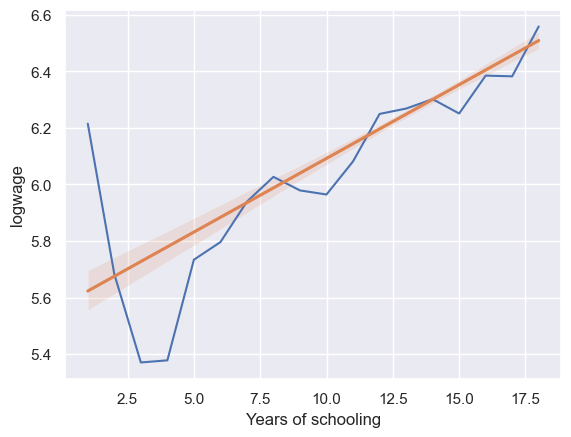

In [3]:
##plot log wages against education
sns.set_theme()
plot = sns.lineplot(data=df, y='lwage', x='educ', ci=None, )
plot = sns.regplot(data=df, y='lwage', x='educ', scatter=False, ci=95)
plot.set(xlabel='Years of schooling', ylabel='logwage')
plt.show()


In [36]:
##Regress log wages (lwage) against education and include controls, use robust standard errors.

from linearmodels.panel import compare

covariates = ['momdad14','sinmom14','step14','libcrd14','fatheduc','motheduc','enroll']


# Prepare the data
df = df.dropna(subset=['lwage', 'educ'] + covariates)
X1 = sm.add_constant(df['educ'])
X2 = sm.add_constant(df[['educ'] + covariates])

# Fit the models
ols = sm.OLS(df['lwage'], X1).fit(cov_type='HC1')  # HC1 for robust standard errors
ols2 = sm.OLS(df['lwage'], X2).fit(cov_type='HC1')

# Compare models
print(summary_col([ols, ols2], stars=True, model_names=['OLS', 'OLS with Controls']))


                  OLS    OLS with Controls
------------------------------------------
R-squared      0.0769    0.1100           
R-squared Adj. 0.0765    0.1067           
const          5.6435*** 5.5918***        
               (0.0486)  (0.0800)         
educ           0.0471*** 0.0382***        
               (0.0035)  (0.0040)         
enroll                   -0.1793***       
                         (0.0317)         
fatheduc                 0.0027           
                         (0.0034)         
libcrd14                 0.0771***        
                         (0.0211)         
momdad14                 0.0077           
                         (0.0639)         
motheduc                 0.0100**         
                         (0.0040)         
sinmom14                 0.0814           
                         (0.1103)         
step14                   -0.1853**        
                         (0.0792)         
Standard errors in parentheses.
* p<.1, ** p<.05, ***

**What are other possible confunders?**


Age,experience.

### 2SLS

You will use only on proximity to a 4-years college ($nearc4$) as instrument. 

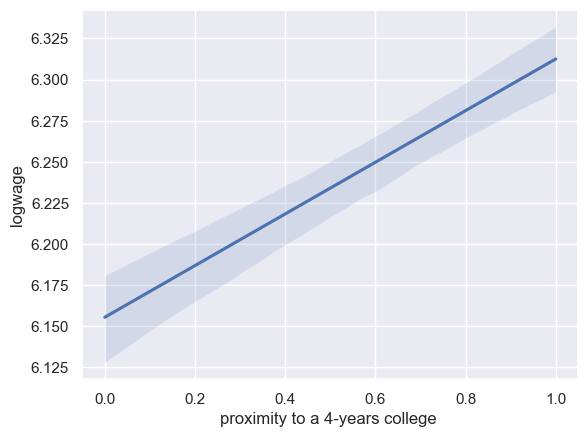

In [5]:
##plot log wages against nearc4

sns.set_theme()

plot = sns.regplot(data=df, y='lwage', x='nearc4', scatter=False, ci=95)
plot.set(xlabel='proximity to a 4-years college ', ylabel='logwage')
plt.show()


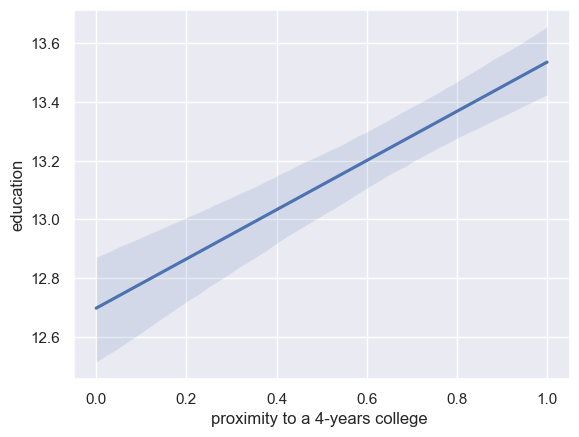

In [6]:
##plot education against nearc4

sns.set_theme()

plot = sns.regplot(data=df, y='educ', x='nearc4', scatter=False, ci=95)
plot.set(xlabel='proximity to a 4-years college ', ylabel='education')
plt.show()


**If you run an IV regression of log wages on education, using college proximity as an instrument for education, what would you expect the sign of the coefficient on education to be? Why?**

It should be positive, meaning that the education coefficient should increase because lots of confounders are negatively correlated with education and positively correlated with parents income. Using iv should elliminate this biases.

In [39]:
##run a regression of education on nearc4, adding the controls you selected before and using robust standard errors


df = df.dropna(subset=['educ', 'nearc4','lwage'] + covariates)

# Prepare the data for the first model (only nearc4 as an exogenous variable)
X1 = sm.add_constant(df[['nearc4']])  # adding a constant for intercept

# Fit the first model
fs = sm.OLS(df['educ'], X1).fit(cov_type='HC1')  # HC1 for robust standard errors

# Prepare the data for the second model (nearc4 and control variables)
X2 = sm.add_constant(df[['nearc4'] + covariates])

# Fit the second model
fs2 = sm.OLS(df['educ'], X2).fit(cov_type='HC1')

# Compare models
from statsmodels.iolib.summary2 import summary_col
print(summary_col([fs, fs2], stars=True, model_names=['OLS', 'OLS with Controls']))
fs_coef = fs2.params[1]



                  OLS     OLS with Controls
-------------------------------------------
R-squared      0.0160     0.2884           
R-squared Adj. 0.0155     0.2858           
const          13.1433*** 9.6221***        
               (0.1007)   (0.4726)         
enroll                    0.8248***        
                          (0.1344)         
fatheduc                  0.1930***        
                          (0.0170)         
libcrd14                  0.8021***        
                          (0.1146)         
momdad14                  -0.6176          
                          (0.4398)         
motheduc                  0.1772***        
                          (0.0210)         
nearc4         0.7066***  0.2360**         
               (0.1198)   (0.1020)         
sinmom14                  -0.7906          
                          (0.7822)         
step14                    -1.3878***       
                          (0.5011)         
Standard errors in parentheses.

In [17]:
##predict education from the previous regression
df['educhat'] = fs2.predict(X2)

In [38]:
##run a regression of log wages on education and controls using robust standard errors



X1 = sm.add_constant(df[['educhat'] ])
twosls = sm.OLS(df['lwage'], X1).fit(cov_type='HC1')

X2 = sm.add_constant(df[['educhat'] + covariates])
twosls2 =fs = sm.OLS(df['lwage'], X2).fit(cov_type='HC1')

rf_coef = twosls2.params[1]
print(summary_col([twosls, twosls2], stars=True, model_names=['OLS', 'OLS with Controls']))


                  OLS    OLS with Controls
------------------------------------------
R-squared      0.0508    0.0834           
R-squared Adj. 0.0504    0.0801           
const          5.3138*** 2.0576**         
               (0.0990)  (0.8017)         
educhat        0.0713*** 0.3997***        
               (0.0073)  (0.0817)         
enroll                   -0.4822***       
                         (0.0758)         
fatheduc                 -0.0682***       
                         (0.0163)         
libcrd14                 -0.2250***       
                         (0.0716)         
momdad14                 0.2440***        
                         (0.0831)         
motheduc                 -0.0535***       
                         (0.0150)         
sinmom14                 0.3611***        
                         (0.1286)         
step14                   0.3361**         
                         (0.1421)         
Standard errors in parentheses.
* p<.1, ** p<.05, ***

In [37]:
##compare the 2sls and ols estimates 
print(summary_col([ols2, twosls2], float_format='%0.3f',  info_dict={'N':lambda x: "{0:d}".format(int(x.nobs))}, regressor_order=['educ', 'educhat']))


               lwage I lwage II
-------------------------------
educ           0.038           
               (0.004)         
educhat                0.400   
                       (0.082) 
const          5.592   2.058   
               (0.080) (0.802) 
enroll         -0.179  -0.482  
               (0.032) (0.076) 
fatheduc       0.003   -0.068  
               (0.003) (0.016) 
libcrd14       0.077   -0.225  
               (0.021) (0.072) 
momdad14       0.008   0.244   
               (0.064) (0.083) 
motheduc       0.010   -0.054  
               (0.004) (0.015) 
sinmom14       0.081   0.361   
               (0.110) (0.129) 
step14         -0.185  0.336   
               (0.079) (0.142) 
R-squared      0.110   0.083   
R-squared Adj. 0.107   0.080   
N              2216    2216    
Standard errors in parentheses.


In [40]:
beta_iv = rf_coef/fs_coef
print(beta_iv)

1.6935648156915235


**What do you think the difference in the estimates is due to?**

Our instrument removes bias when trying to explain earnings by the level of education. One possible explanation could be that by predicting the education level primarly by how much a person lives near a college, we omit lots of people that are wealthy and have the possibility of affording to live outside his hometown. Doing this, people that are already facilitated in having a possible prosperous future without education aren't taken account, or at least less.

### IV analysis

In [46]:
##use IV2sls to run the regression of log wages on education. using college proximity as an instrument for education
##add the same controls as 
from linearmodels.iv import IV2SLS

exog = sm.add_constant(df[covariates])




iv_set = df[['nearc4']]

iv2sls = IV2SLS(df.lwage, exog, df.educ, iv_set).fit(cov_type='robust')

print(iv2sls)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                  lwage   R-squared:                     -3.1208
Estimator:                    IV-2SLS   Adj. R-squared:                -3.1357
No. Observations:                2216   F-statistic:                    42.333
Date:                Thu, Nov 16 2023   P-value (F-stat)                0.0000
Time:                        19:55:25   Distribution:                  chi2(8)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          2.0576     1.7236     1.1938     0.2326     -1.3206      5.4359
momdad14       0.2440     0.2100     1.1621     0.24